In [1]:
import pandas as pd
import numpy as np
import os
import csv

In [2]:
type_of_interest = 'Term'

entity2id  = {}
id2entity  = {}
cid2entity = {}

cid = 0
with open("./train/entities.tsv", newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile, delimiter='\t', fieldnames=['id','entity'])
    for row_val in reader:
        type = row_val['entity'].split('::')[0]
        if type != type_of_interest:
            continue
        
        id = row_val['id']
        entity = row_val['entity']

        entity2id[entity] = int(id)
        id2entity[int(id)] = entity
        cid2entity[cid] = entity
        cid += 1

print("Number of entities in the type: {}".format(len(entity2id)))

Number of entities in the type: 2548


In [3]:
def get_entity_name_mapping(type_of_interest):
    
    attribute_file = '/fs/ess/PCON0041/Ziqi/AACT/build_graph/attributes/' + type_of_interest.lower()+'_attribute.txt'
    entity2name = {}
    
    with open(attribute_file, 'r') as f:
        for line in f.readlines():
            try:
                idx, _, name, _ = line.rstrip('\n').split(',', 3)
            except:
                idx, _, name = line.rstrip('\n').split(',', 2)
            idx = idx.replace(':', '::').replace('ID', '')
            entity2name[idx] = name
    
    return entity2name

In [4]:
if type_of_interest != 'Study':
    entity2name = get_entity_name_mapping(type_of_interest)

In [5]:
entity_emb = np.load('./ckpts/results_in_paper/CTKG_TransE_l2_entity.npy')

idx = np.asarray(list(id2entity.keys()), dtype=int)
entity_emb = entity_emb[idx]

print(entity_emb.shape)

(2548, 200)


In [6]:
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(entity_emb)
# cleanup self-compare and dup-compare
s = similarity < 0.99
s = np.unique(similarity[s])

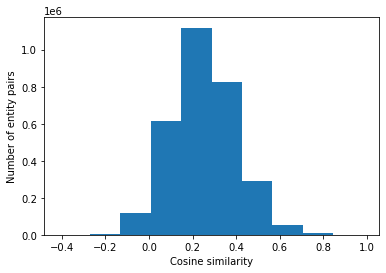

In [7]:
import matplotlib.pyplot as plt
plt.xlabel('Cosine similarity')
plt.ylabel('Number of entity pairs')
plt.hist(s)
plt.show()

In [8]:
import pdb
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(entity_emb)
np.save(type_of_interest+'_similarity', similarity)
idx = np.flip(np.argsort(similarity), axis=1)

with open(type_of_interest+'_entityName.txt', 'w') as f:
    for i in range(idx.shape[0]):
        if type_of_interest == 'Study':
            f.write(cid2entity[i]+'\n')
        else:
            f.write(entity2name[cid2entity[i]]+'\n')


max_pairs = []
for i in range(idx.shape[0]):
    j = 1
    while (similarity[i][idx[i][j]] > 0.5):
        if type_of_interest == 'Study':
            max_pairs.append((cid2entity[idx[i][0]], cid2entity[idx[i][j]], similarity[i][idx[i][j]]))
        else:
            max_pairs.append((entity2name[cid2entity[idx[i][0]]], entity2name[cid2entity[idx[i][j]]], similarity[i][idx[i][j]]))
        j += 1

def sort_score(pair):
    return pair[2]

max_pairs.sort(reverse=True, key=sort_score)
sim_pairs = []
for i, pair in enumerate(max_pairs):
    if i % 2 == 0:
        sim_pairs.append(pair)

sim_pairs[:20]

[('"Sunitinib"', '"abaloparatide"', 0.9968193),
 ('"Gefarnate"', '"leo 80185"', 0.996232),
 ('"Interleukin-2"', '"Glycosaminoglycans"', 0.9945157),
 ('"ril-21"', '"Rilotumumab"', 0.99410427),
 ('"benazepril"', '"Clomiphene"', 0.99270356),
 ('"Vasoconstrictor Agents"', '"pd-0332991"', 0.9853355),
 ('"cb-183"', '"Aspartate Aminotransferases"', 0.98258775),
 ('"Imipenem"', '"Enoxaparin"', 0.98235387),
 ('"Mydriatics"', '"ly2216684"', 0.98150253),
 ('"oraplus"', '"Vincristine"', 0.98022765),
 ('"Yttrium-90"', '"Substance P"', 0.97824264),
 ('"L-BLP25"', '"Acitretin"', 0.97557855),
 ('"Rilotumumab"', '"Acetates"', 0.97530264),
 ('"ivacaftor"', '"Benzodioxoles"', 0.97392225),
 ('"DNA', '"Cosmetics"', 0.97356576),
 ('"Nitrofurantoin"', '"Xalacom"', 0.9700233),
 ('"Enalapril"', '"Substance P"', 0.9694458),
 ('"Caffeine"', '"Amphetamines"', 0.96895427),
 ('"Exenatide"', '"Oxadiazoles"', 0.9679967),
 ('"Sulfamethoxazole"', '"Acrylic Resins"', 0.96656275)]

In [9]:
similarity.mean()

0.25388163

In [10]:
#max_pairs[1]

In [11]:
#max_pairs[1][0]

In [12]:
#for i, pair in enumerate(max_pairs):
#    if pair[0] == 'Study::NCT02105688' and pair[2] > 0.5:
#        print(pair)